# ROI analysis

## Python imports

In [3]:
import matplotlib.pyplot as pyplt
import matplotlib.ticker
import os
import numpy as np
import pandas as pd
import sklearn.metrics 
import seaborn
import time

## Derive confusion matrix plots

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


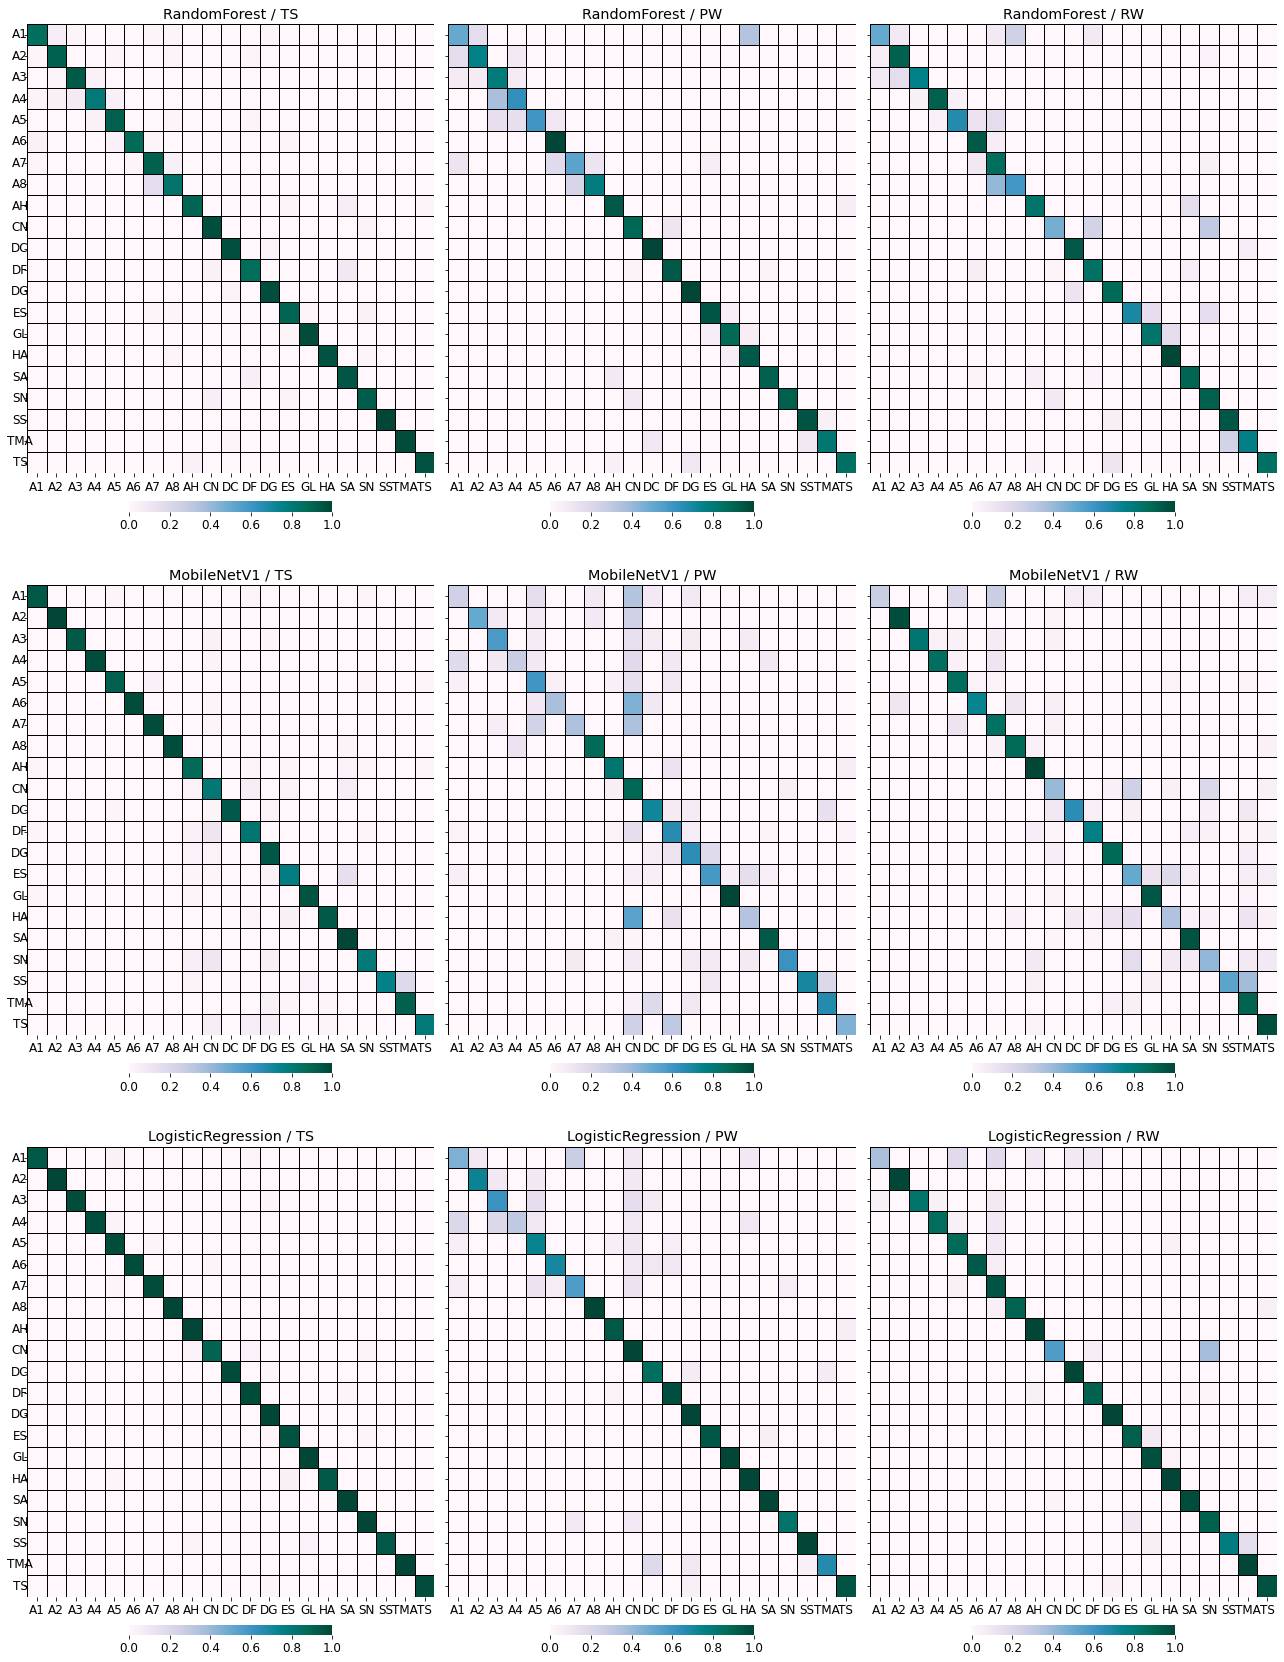

In [4]:
def heatmap(model_type, model_id, dataset_id, plt):
    data = pd.read_csv('results/' + model_type + '/' + model_id +  '_' + dataset_id + '.tsv', sep='\t')
    data.replace({ 
                 'AT_I1': 'A1', 
                 'AT_M': 'A2', 
                 'AT_CH': 'A3',
                 'AT_S': 'A4',
                 'AT_I2': 'A5',
                 'AT_CA': 'A6',  
                 'AT_O1': 'A7', 
                 'AT_O2': 'A8' },inplace=True)    
    df = data[['label','prediction','source']].groupby(['label','prediction']).count() 
    #print(df)
    
    df2 =  data[['label','time']].groupby('label').count()
    #print(df2)
    df = df.reset_index().merge(df2,on='label')

    df['value'] = df['source'] / df['time']
    confusion_matrix = df.reset_index().pivot_table(index='label', columns='prediction', fill_value=0.0, values='value')
    #print(confusion_matrix.reset_index() / count_values['time'])
    
    plt = seaborn.heatmap(confusion_matrix,cmap='PuBuGn', 
                          cbar_kws = { 'location': 'bottom', 'shrink': 0.5, 'pad': 0.05 },
                         vmin=0.0, vmax=1.0, linewidths=1, linecolor='black', square=False,ax=plt )
    plt.set_xticklabels(df['label'].unique(), rotation=0, ha='center')
    plt.set_yticklabels(df['label'].unique(), rotation=0, ha='center')
    plt.set_title(model_id + ' / ' + dataset_id)
    plt.set_xlabel('')
    plt.set_ylabel('')

font = {'family' : 'normal',
        'size'   : 12}
pyplt.rc('font', **font)
pyplt.rcParams["figure.figsize"] = (18,24)

f, p = pyplt.subplots(3,3,sharey=True)
heatmap('brssi', 'RandomForest', 'TS', p[0][0])
heatmap('brssi', 'RandomForest', 'PW', p[0][1])
heatmap('brssi', 'RandomForest', 'RW', p[0][2])
heatmap('vision', 'MobileNetV1', 'TS', p[1][0])
heatmap('vision', 'MobileNetV1', 'PW', p[1][1])
heatmap('vision', 'MobileNetV1', 'RW', p[1][2])
heatmap('hybrid', 'LogisticRegression', 'TS', p[2][0])
heatmap('hybrid', 'LogisticRegression', 'PW', p[2][1])
heatmap('hybrid', 'LogisticRegression', 'RW', p[2][2])
f.tight_layout()
f.get_figure().savefig("room_analysis.pdf")

## Derive overview plots

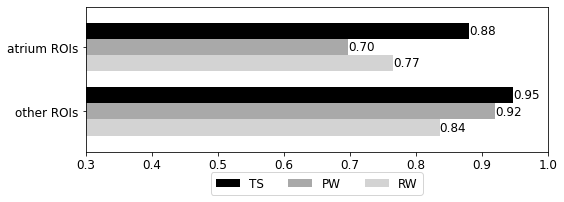

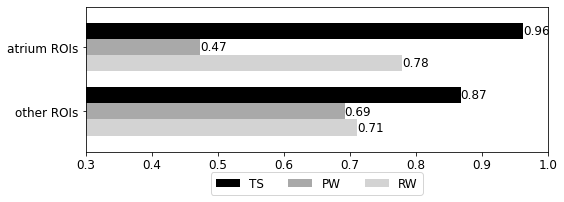

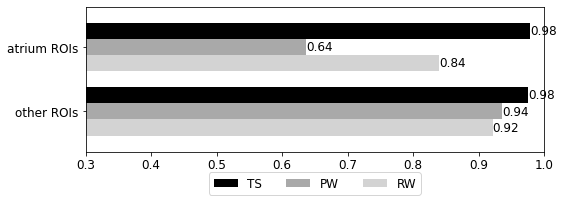

In [16]:
def analyse(model_type, model_id, dataset_id):
    df = pd.read_csv('results/' + model_type + '/' + model_id +  '_' + dataset_id + '.tsv', sep='\t')
    df['correct'] = (df['label'] == df['prediction']).astype(float)
    rdf = df[['label','correct']].groupby('label').mean()
    avg = df['correct'].mean()
    rdf.reset_index(inplace=True)
    rdf.rename(columns={ 'correct': dataset_id}, inplace=True)
    avg_at = rdf[rdf.label.str.startswith('AT_')][dataset_id].mean()
    avg_non_at = rdf[~ rdf.label.str.startswith('AT_')][dataset_id].mean()
    tmp = pd.DataFrame([['atrium ROIs',avg_at],['other ROIs',avg_non_at]],columns=['label',dataset_id])
    return tmp #pd.concat([tmp,rdf])

def analyse_rooms(model_type, id):
    df1 = analyse(model_type, id, 'TS')
    df2 = analyse(model_type, id, 'PW')
    df3 = analyse(model_type, id, 'RW')
    df = df1.merge(df2.merge(df3))
    df['id'] = id
    return df
def make_plot(plt,model_type, model_id):
    df = analyse_rooms(model_type, model_id)
    plt = df.plot.barh(x='label',y=['TS','PW','RW'],color=['black','darkgray','lightgray',],width=0.75)
    plt.legend(loc='upper center',ncol=3, bbox_to_anchor=(0.5,-0.1))
    plt.set_xlabel('')
    plt.set_ylabel('')
    plt.set_xlim([0.3, 1.0])
    plt.invert_yaxis()
    for container in plt.containers:
      plt.bar_label(container,fmt='%.2f')
    plt.get_figure().tight_layout()
    #plt.get_figure().set_linewidth(0)
    plt.get_figure().savefig('rom_analysis_'+model_id+'.pdf')


pyplt.rcParams["figure.figsize"] = (8,3)
make_plot(None, 'brssi', 'RandomForest')
make_plot(None, 'vision', 'MobileNetV1')
make_plot(None, 'hybrid', 'LogisticRegression')